## Exercise 3 - Quantum error correction

### Importing Packages

In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile
from qc_grader import grade_ex3
import qiskit.tools.jupyter
from qiskit.test.mock import FakeTokyo

#### --------------------------------------------------------------------------------------------------------------------

### 1. Circuit

In this example we'll use 5 qubits that we'll call code qubits. To keep track of them, we'll define a special quantum register.

In [17]:
code = QuantumRegister(5,'code')

We'll also have an additional four qubits we'll call syndrome qubits.

In [18]:
syn = QuantumRegister(4,'syn')

Similarly we define a register for the four output bits, used when measuring the syndrome qubits.

In [19]:
out = ClassicalRegister(4,'output')

We consider the qubits to be laid out as follows, with the code qubits forming the corners of four triangles, and the syndrome qubits living inside each triangle.

```
c0----------c1
| \   s0   / |
|   \    /   |
| s1  c2  s2 |
|   /    \   |
| /   s3   \ |
c3----------c4
```

For each triangle we associate a stabilizer operation on its three qubits. For the qubits on the sides, the stabilizers are $ZZZ$. For the top and bottom ones, they are $XXX$.

The syndrome measurement circuit corresponds to a measurement of these observables. This is done in a similar way to surface code stabilizers (in fact, this code is a small version of a surface code).

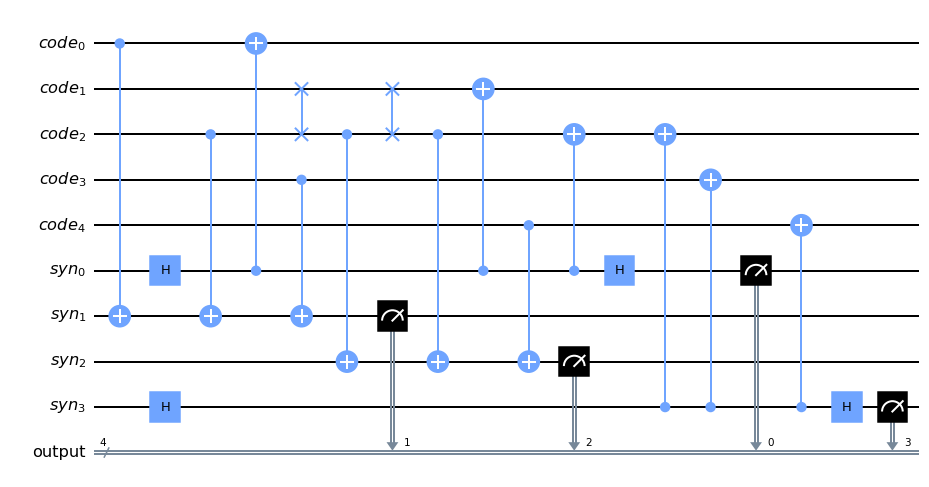

In [20]:
qc_syn = QuantumCircuit(code,syn,out)


# Left ZZZ
qc_syn.cx(code[0],syn[1])
qc_syn.cx(code[2],syn[1])
qc_syn.cx(code[3],syn[1])
#qc_syn.barrier()

# Right ZZZ
qc_syn.swap(code[1],code[2])
qc_syn.cx(code[2],syn[2])
qc_syn.swap(code[1],code[2])
qc_syn.cx(code[2],syn[2])
qc_syn.cx(code[4],syn[2])
#qc_syn.barrier()

# Top XXX
qc_syn.h(syn[0])
qc_syn.cx(syn[0],code[0])
qc_syn.cx(syn[0],code[1])
qc_syn.cx(syn[0],code[2])
qc_syn.h(syn[0])
#qc_syn.barrier()

# Bottom XXX
qc_syn.h(syn[3])
qc_syn.cx(syn[3],code[2])
qc_syn.cx(syn[3],code[3])
qc_syn.cx(syn[3],code[4])
qc_syn.h(syn[3])
#qc_syn.barrier()


# Measure the auxilliary qubits
qc_syn.measure(syn,out)
qc_syn.draw('mpl')

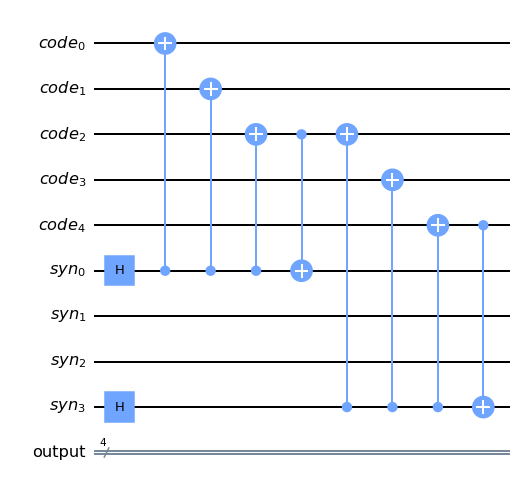

In [21]:
qc_init = QuantumCircuit(code,syn,out)

qc_init.h(syn[0])
qc_init.cx(syn[0],code[0])
qc_init.cx(syn[0],code[1])
qc_init.cx(syn[0],code[2])
qc_init.cx(code[2],syn[0])

qc_init.h(syn[3])
qc_init.cx(syn[3],code[2])
qc_init.cx(syn[3],code[3])
qc_init.cx(syn[3],code[4])
qc_init.cx(code[4],syn[3])

#qc_init.barrier()
qc_init.draw('mpl')

The initialization circuit prepares an eigenstate of these observables, such that the output of the syndrome measurement will be `0000` with certainty.

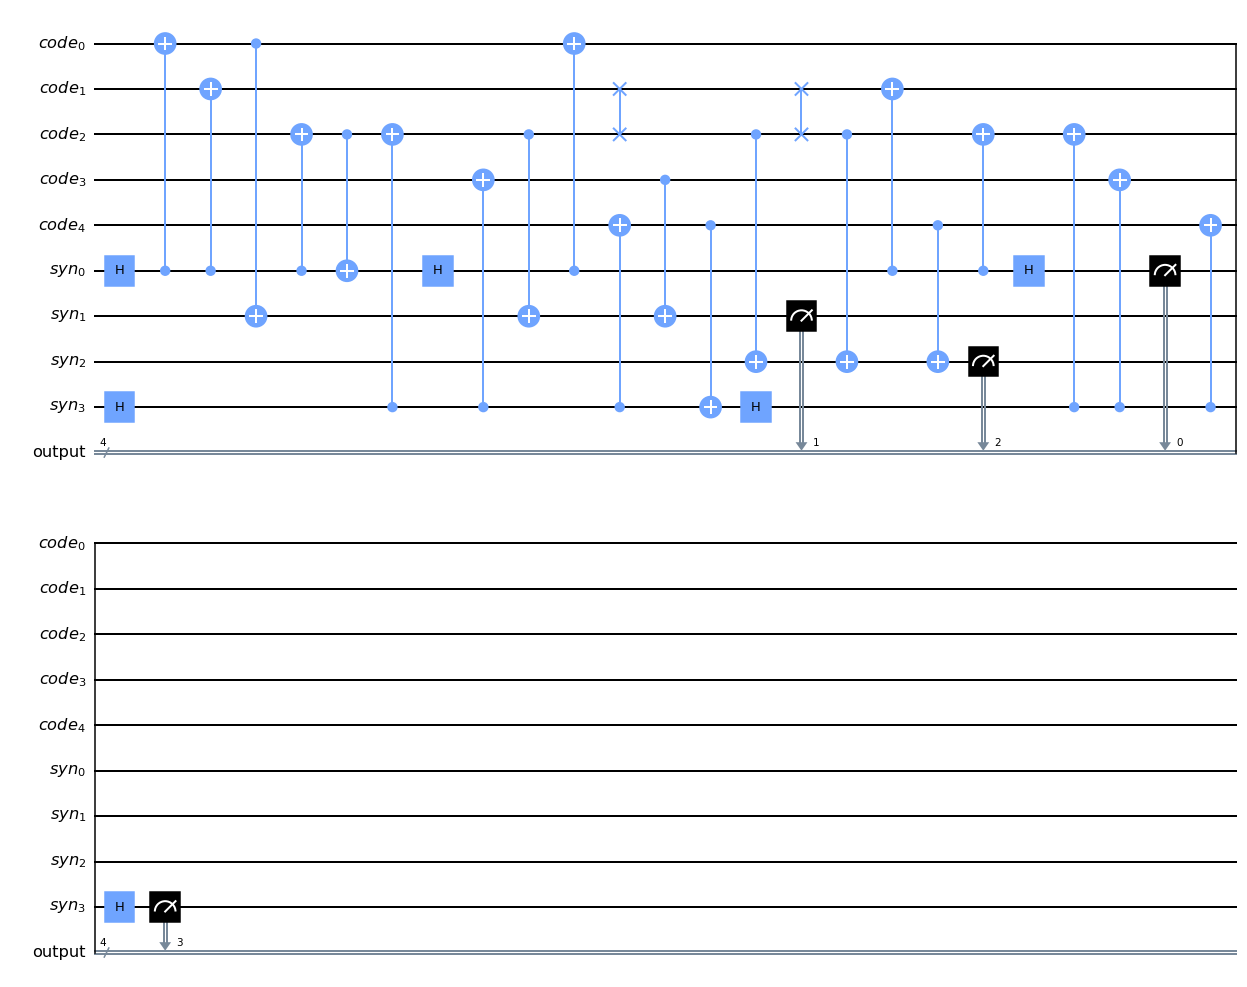

{'0000': 1024}

In [22]:
qc = qc_init.compose(qc_syn)
display(qc.draw('mpl'))

job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

#### --------------------------------------------------------------------------------------------------------------------

### 2. Error Qubits

In [23]:
error_qubits = [0,4]

Here 0 and 4 refer to the positions of the qubits in the following list, and hence are qubits `code[0]` and `code[4]`.

In [24]:
qc.qubits

[Qubit(QuantumRegister(5, 'code'), 0),
 Qubit(QuantumRegister(5, 'code'), 1),
 Qubit(QuantumRegister(5, 'code'), 2),
 Qubit(QuantumRegister(5, 'code'), 3),
 Qubit(QuantumRegister(5, 'code'), 4),
 Qubit(QuantumRegister(4, 'syn'), 0),
 Qubit(QuantumRegister(4, 'syn'), 1),
 Qubit(QuantumRegister(4, 'syn'), 2),
 Qubit(QuantumRegister(4, 'syn'), 3)]

To check that the code does as we require, we can use the following function to create circuits for inserting artificial errors. Here the errors we want to add are listed in `errors` as a simple text string, such as `x0` for an `x` on `error_qubits[0]`.

In [25]:
def insert(errors,error_qubits,code,syn,out):

    qc_insert = QuantumCircuit(code,syn,out)

    if 'x0' in errors:
        qc_insert.x(error_qubits[0])
    if 'x1' in errors:
        qc_insert.x(error_qubits[1])
    if 'z0' in errors:
        qc_insert.z(error_qubits[0])
    if 'z1' in errors:
        qc_insert.z(error_qubits[1])
        
    return qc_insert

Rather than all 16 possibilities, let's just look at the four cases where a single error is inserted.

In [26]:
for error in ['x0','x1','z0','z1']:
    
    qc = qc_init.compose(insert([error],error_qubits,code,syn,out)).compose(qc_syn)
    job = Aer.get_backend('qasm_simulator').run(qc)
    
    print('\nFor error '+error+':')
    counts = job.result().get_counts()
    for output in counts:
        print('Output was',output,'for',counts[output],'shots.')


For error x0:
Output was 0010 for 1024 shots.

For error x1:
Output was 0100 for 1024 shots.

For error z0:
Output was 0001 for 1024 shots.

For error z1:
Output was 1000 for 1024 shots.


### 2. Backend

In [27]:
backend = FakeTokyo()
backend

<FakeTokyo('fake_tokyo') from None()>

As a simple idea of how our original circuit is laid out, let's see how many two-qubit gates it contains.

In [28]:
qc = qc_init.compose(qc_syn)
qc = transpile(qc, basis_gates=['u','cx'])
qc.num_nonlocal_gates()

26

In [29]:
qc1 = transpile(qc,backend,basis_gates=['u','cx'], optimization_level=3)
qc1.num_nonlocal_gates()

26

#### --------------------------------------------------------------------------------------------------------------------

### 3. Initial Layout

In [30]:
initial_layout = [0,2,6,10,12,1,5,7,11]

In [31]:
qc2 = transpile(qc,backend,initial_layout=initial_layout, basis_gates=['u','cx'], optimization_level=3)
qc2.num_nonlocal_gates()

26

#### --------------------------------------------------------------------------------------------------------------------

### 4. Grading

In [32]:
grade_ex3(qc_init,qc_syn,error_qubits,initial_layout)

Grading your answer for ex3. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 266.
Feel free to submit your answer.



#### --------------------------------------------------------------------------------------------------------------------